In [22]:
# Import das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

# Coleta e organização dos dados

In [23]:
# Baixa os dados do meu repositório do github
!wget -O fabrica_energia.zip https://github.com/gabrielteixeira021/4UBD/raw/refs/heads/main/Fabrica-Inteligente/fabrica_energia.zip

# Realiza a extração dos dados
!unzip fabrica_energia.zip


--2025-10-14 14:49:59--  https://github.com/gabrielteixeira021/4UBD/raw/refs/heads/main/Fabrica-Inteligente/fabrica_energia.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielteixeira021/4UBD/refs/heads/main/Fabrica-Inteligente/fabrica_energia.zip [following]
--2025-10-14 14:49:59--  https://raw.githubusercontent.com/gabrielteixeira021/4UBD/refs/heads/main/Fabrica-Inteligente/fabrica_energia.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272 [application/zip]
Saving to: ‘fabrica_energia.zip’

fabrica_energia.zip 100%[===================>]     272  --.-KB/s    in 0s      

2025-10-14

# Manipulação dos dados

In [24]:
# Carregar CSV
df = pd.read_csv('fabrica_energia.csv')

# Média, desvio padrão e total por máquina
for maquina in df['maquina'].unique():
    dados_maquina = df[df['maquina'] == maquina]
    print(f'Máquina {maquina}:')
    print(' Média consumo:', dados_maquina['consumo_kwh'].mean())
    print(' Desvio padrão:', dados_maquina['consumo_kwh'].std())
    print(' Total consumido:', dados_maquina['consumo_kwh'].sum())

# Maior e menor produção
dia_maior_prod = df.loc[df['unidades_produzidas'].idxmax(), 'dia']
dia_menor_prod = df.loc[df['unidades_produzidas'].idxmin(), 'dia']
print(f'Dia de maior produção: {dia_maior_prod}')
print(f'Dia de menor produção: {dia_menor_prod}')


Máquina A:
 Média consumo: 269.0
 Desvio padrão: 38.47076812334269
 Total consumido: 1345
Máquina B:
 Média consumo: 330.0
 Desvio padrão: 22.360679774997898
 Total consumido: 1650
Dia de maior produção: 6
Dia de menor produção: 5


# Visualização dos dados

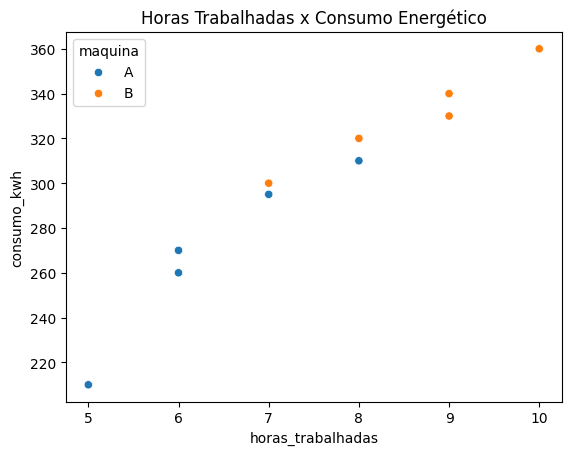

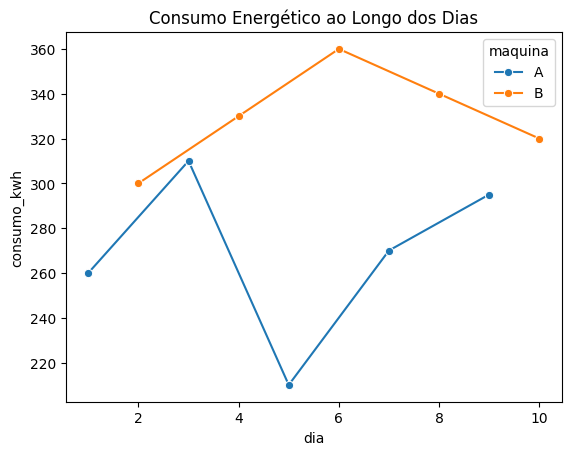

In [25]:
# Dispersão: horas trabalhadas vs consumo energético
plt.figure()
sns.scatterplot(x='horas_trabalhadas', y='consumo_kwh', hue='maquina', data=df)
plt.title('Horas Trabalhadas x Consumo Energético')
plt.show()

# Linha: consumo energético ao longo dos dias
plt.figure()
sns.lineplot(x='dia', y='consumo_kwh', hue='maquina', data=df, marker="o")
plt.title('Consumo Energético ao Longo dos Dias')
plt.show()


# Classificação com Scikit-learn

In [26]:
# Adicionar coluna altoconsumo
df['media_maquina'] = df.groupby('maquina')['consumo_kwh'].transform('mean')
df['altoconsumo'] = (df['consumo_kwh'] > df['media_maquina']).astype(int)

# Treinamento do modelo
X = df[['horas_trabalhadas', 'unidades_produzidas']]
y = df['altoconsumo']
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Previsão de exemplo
print('Previsão altoconsumo:', clf.predict(X))


Previsão altoconsumo: [0 0 1 0 0 1 1 1 1 0]


In [27]:
# Exemplo de previsão para novo dado
# Substitua os valores conforme desejado
novo_dado = [[8, 70]]  # Exemplo: 8 horas trabalhadas, 70 unidades produzidas
previsao_altoconsumo = clf.predict(novo_dado)
print('Previsão de alto consumo para novo dado:', previsao_altoconsumo)

Previsão de alto consumo para novo dado: [1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# Rede Neural com Tensor-Flow

In [28]:
# Entradas (X) e saída (y)
X_nn = df[['horas_trabalhadas', 'unidades_produzidas']].values
y_nn = df['consumo_kwh'].values

# Normalização simples
X_nn = X_nn / np.max(X_nn, axis=0)

# Montagem do modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_nn, y_nn, epochs=200, verbose=0)

# Previsão (corrigida para khw)
print('Previsão consumo:', (model.predict(X_nn) * df['consumo_kwh'].max()).flatten())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Previsão consumo: [570.51843 615.3313  660.1442  724.8483  505.81433 779.6068  560.5728
 708.27234 625.2769  670.08984]


In [29]:
# Exemplo de previsão para novo dado
novo_X = np.array([[8, 70]])  # 8 horas trabalhadas, 70 unidades produzidas

# Normalização
novo_X = novo_X / np.max(df[['horas_trabalhadas', 'unidades_produzidas']].values, axis=0)

# Realiza a predição
consumo_predito_normalizado = model.predict(novo_X)
# Converte a saída para kwh
consumo_predito_real = consumo_predito_normalizado * df['consumo_kwh'].max()

# Exibe a saída
print('Previsão de consumo_kwh real para novo dado:', consumo_predito_real.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Previsão de consumo_kwh real para novo dado: [653.51385]
